In [115]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [116]:
# aka env variables
BASE_DIR = '/kaggle/input/airbus-ship-detection'
TEST_IMG_DIR = os.path.join(BASE_DIR,'test_v2')
TRAIN_IMG_DIR = os.path.join(BASE_DIR,'train_v2')
TRAIN_DATASET_CSV = os.path.join(BASE_DIR,'train_ship_segmentations_v2.csv')

In [117]:
# read dataset
df = pd.read_csv(TRAIN_DATASET_CSV)

# add info about ship beeing present in the image
df['has_ship'] = df['EncodedPixels'].apply(lambda x: 0 if pd.isna(x) else 1)

# add info about total number of ships at the image
df['ship_count'] = df.groupby('ImageId')['EncodedPixels'].transform('count')

# concat EncodedPixels tp AllEncodedPixels
df['AllEncodedPixels'] = df.groupby('ImageId')['EncodedPixels'].transform(
    lambda x: np.nan if x.isna().all() else ' '.join(filter(None, x))
)

# remove repeating images
df = df.drop_duplicates(subset='ImageId', keep='first')

# delete EncodedPixels column
df = df.drop(columns=['EncodedPixels'])

# reset indexes
df = df.reset_index(drop=True)

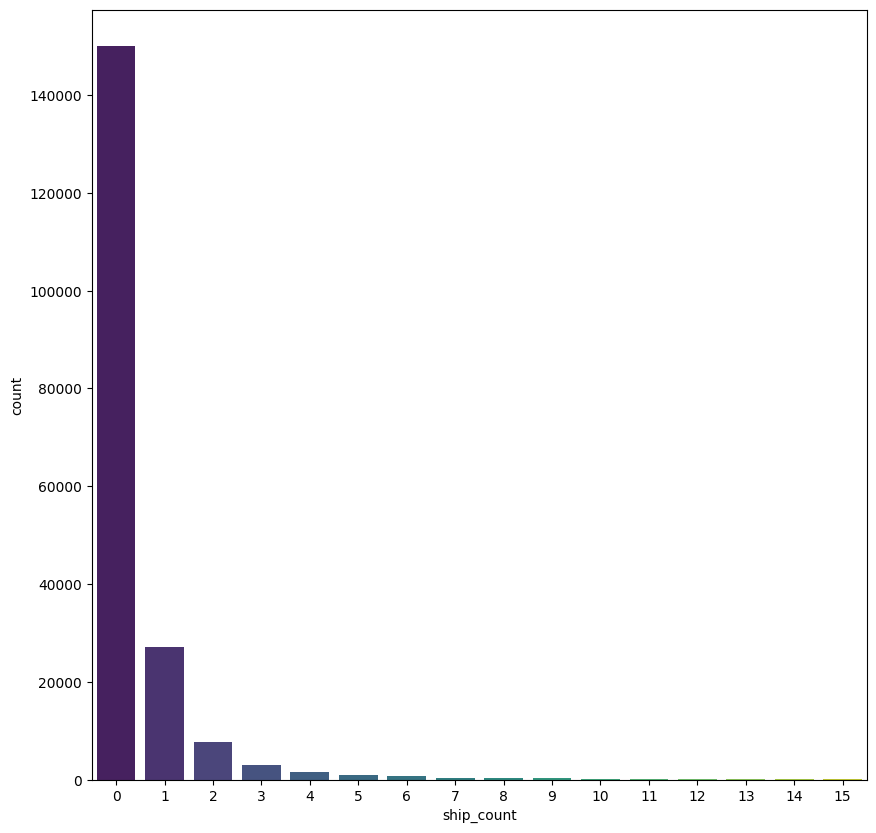

In [118]:
plt.figure(figsize=(10,10))
sns.countplot(x='ship_count', data=df, palette='viridis')
plt.show()

In [119]:
print(f"Total number of images with no ships - {len(df.loc[df['ship_count'] == 0])}")
print(f"Total number of images with at least one ship - {len(df.loc[df['ship_count'] > 0])}")


Total number of images with no ships - 150000
Total number of images with at least one ship - 42556


Upon examining the dataset, it is clear that the data is highly imbalanced. The total number of empty images is approximately three times higher than the number of images containing ships. To ensure accurate analysis and modeling, the dataset will require rebalancing.

In [120]:
# drop images with no ships for further eda
df = df[df['has_ship'] > 0]

In [121]:
# function to calculate the size of bitmask
def calc_mask_size(pixelStr: str):
    if (pixelStr == pixelStr):
        split = pixelStr.split(" ")
        lengthP = np.array(split[1::2], dtype=int)
        return lengthP.sum()
    else:
        return 0

In [122]:
# calculate the mask area in pixels
df['MaskSize'] = df['AllEncodedPixels'].apply(calc_mask_size)
# calculate the mask size as a percentage of the total image size
df['MaskSizePercentage'] = df['MaskSize']*100/(768*768)


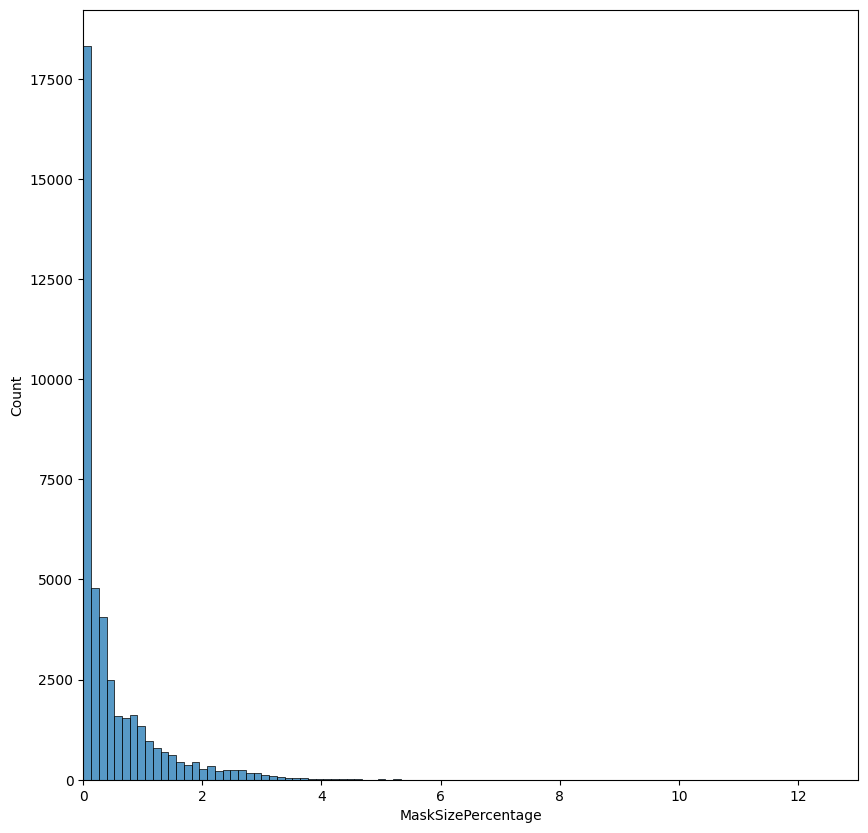

In [123]:
# plot graph of MaskSizePercentage distribution
plt.figure(figsize=(10,10))
sns.histplot(x='MaskSizePercentage', data=df, bins=100, kde=False)
plt.xlim(0, df['MaskSizePercentage'].max())
plt.yscale('linear')
plt.show()

In [124]:
print(f"Total number if images with ship mask area beeing between [0.0, 0.3] - {len(df[(df['MaskSizePercentage'] > 0) & (df['MaskSizePercentage'] <= 0.03)])}")
print(f"Total number if images with ship mask area beeing between [0.03, 0.1] - {len(df[(df['MaskSizePercentage'] > 0.03) & (df['MaskSizePercentage'] <= 0.1)])}")
print(f"Total number if images with ship mask area beeing between [0.1, 0.3] - {len(df[(df['MaskSizePercentage'] > 0.1) & (df['MaskSizePercentage'] <= 0.3)])}")

print(f"Total number if images with ship mask area beeing between [0.3, 1] - {len(df[(df['MaskSizePercentage'] > 0.3) & (df['MaskSizePercentage'] <= 1)])}")
print(f"Total number if images with ship mask area beeing between [1, 3] - {len(df[(df['MaskSizePercentage'] > 1) & (df['MaskSizePercentage'] <= 3)])}")
print(f"Total number if images with ship mask area beeing between [3, 10] - {len(df[(df['MaskSizePercentage'] > 3) & (df['MaskSizePercentage'] <= 10)])}")
print(f"Total number if images with ship mask area beeing between [10, 100] - {len(df[(df['MaskSizePercentage'] > 10) & (df['MaskSizePercentage'] <= 100)])}")



Total number if images with ship mask area beeing between [0.0, 0.3] - 9272
Total number if images with ship mask area beeing between [0.03, 0.1] - 7606
Total number if images with ship mask area beeing between [0.1, 0.3] - 7774
Total number if images with ship mask area beeing between [0.3, 1] - 10673
Total number if images with ship mask area beeing between [1, 3] - 6668
Total number if images with ship mask area beeing between [3, 10] - 562
Total number if images with ship mask area beeing between [10, 100] - 1


Since most of the ship masks occupy less than 3% of the total image size, the model will receive a significant amount of data where the majority of the image is water. Assuming this, the images with only water would be deleted from the training dataset.